In [ ]:
import gym_battleship
import gymnasium as gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import BaseCallback
import torch as th
import torch.nn as nn
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.dqn import CnnPolicy
from gym_battleship.environments.battleship import CHANNEL_MAP
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.monitor import Monitor
import os
from typing import Callable
import imageio
from heuristic_agent import HeuristicAgent
from random_agent import RandomAgent


In [ ]:
%load_ext autoreload
%autoreload 2

### Pull the DQN Model from Git LFS (Large File Storage)

In [ ]:
!git lfs pull --include="dqn_models/dqn_model_9/dqn-9.zip"

### Load helper functions for DQN

In [ ]:
def make_battleship_cnn(features_dim: int, hidden_layer1: int, hidden_layer2: int):
    """
        Factory function to create a custom CNN feature exxtractor for the battleship state space representation 
        (a 3-channel 10x10 matrix), using the specified hyperparameters below. 
        
        Args: 
            features_dim = length of the final vector outputted by the feature extractor
            hidden_layer1 = number of nodes in first hidden layer
            hidden_layer2 = number of nodes in second hidden layer
    """
    class BattleshipCNN(BaseFeaturesExtractor):
        def __init__(self, observation_space, features_dim=features_dim):
            super().__init__(observation_space, features_dim)

            n_channels = observation_space.shape[0]  

            self.cnn = nn.Sequential(
                nn.Conv2d(n_channels, hidden_layer1, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.Conv2d(hidden_layer1, hidden_layer2, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.Flatten()
            )

            with th.no_grad():
                sample = th.zeros((1, n_channels, 10, 10))
                sample_out = self.cnn(sample)
                conv_output_dim = sample_out.shape[1]

            self.linear = nn.Sequential(
                nn.Linear(conv_output_dim, features_dim),
                nn.ReLU()
            )

        def forward(self, obs):
            return self.linear(self.cnn(obs))
    
    return BattleshipCNN


In [ ]:
def masked_predict(model, obs):
    """
        Choose the action with highest Q-value among legal actions
    """
    
    obs_tensor = th.as_tensor(obs).unsqueeze(0).float()
    
    with th.no_grad():
        q_values = model.q_net(obs_tensor)
        
    legal_mask = (obs[CHANNEL_MAP.LEGAL_MOVE.value, :, :] == 0).flatten()
    
    # set illegal actions to very negative Q-value
    q_values_masked = q_values.clone()
    q_values_masked[0, ~legal_mask] = -float('inf')
    action = q_values_masked.argmax(dim=1).item()

    return action, q_values

In [ ]:
def get_q_values(model, obs):
    """Get Q-values for all 100 possible actions given the current state"""
    obs_tensor = th.as_tensor(obs).unsqueeze(0).float()
    
    with th.no_grad():
        q_values = model.q_net(obs_tensor)

    return q_values

In [ ]:
def plot_q_value_heatmap(q_values, title="Q-Value Heatmap", image=False):
    """
        Generates a heatmap of the q-values for all 100 possible actions given the current state of the board. 
    """
    q_vals = q_values[0].cpu().numpy()
    
    grid = np.zeros((10, 10))
    for i in range(100):
        row = i // 10
        col = i % 10
        grid[row, col] = q_vals[i]
    
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(grid, cmap='coolwarm', aspect='auto')
    
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Q-Value', rotation=270, labelpad=20)
    
    ax.set_xticks(np.arange(10))
    ax.set_yticks(np.arange(10))
    ax.set_xticklabels(np.arange(10))
    ax.set_yticklabels(np.arange(10))
    
    ax.set_xticks(np.arange(10) - 0.5, minor=True)
    ax.set_yticks(np.arange(10) - 0.5, minor=True)
    ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)
    
    ax.set_xlabel('Column')
    ax.set_ylabel('Row')
    ax.set_title(title)
    
    for i in range(10):
        for j in range(10):
            text = ax.text(j, i, f'{grid[i, j]:.2f}',
                          ha="center", va="center", color="black", fontsize=8)
    
    plt.tight_layout()
    
    if image:
        fig.canvas.draw()
        img = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
        img = img.reshape(fig.canvas.get_width_height()[::-1] + (4,))
        img = img[:, :, :3]
        plt.close(fig)
        return img
    else:
        plt.show()
        return grid

In [ ]:
def plot_histogram(ratios, title="Histogram", x_label="X axis", y_label="Y axis", save_path=None):
    """
    Create a histogram of hit-to-miss ratios for a model
        Args:
            ratios: list of ratios (floats) to plot
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    
    ax.hist(ratios, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    
    mean_ratio = np.mean(ratios)
    median_ratio = np.median(ratios)
    ax.axvline(mean_ratio, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_ratio:.3f}')
    ax.axvline(median_ratio, color='green', linestyle='--', linewidth=2, label=f'Median: {median_ratio:.3f}')
    ax.legend()
    
    plt.tight_layout()
    
    if save_path:
        fig.savefig(save_path, dpi=150)
    
    plt.show()
    plt.close(fig)

In [ ]:
def plot_action_distribution(action_dict, title="Action Distribution", x_label="Action (Grid Position)", y_label="Frequency", display=True, save_path=None):
    """
    Create a histogram showing the distribution of actions taken
    
    Args:
        action_dict: Dictionary mapping action (int) to frequency (int)
        title: Title for the plot
        x_label: Label for x-axis
        y_label: Label for y-axis
        save_path: Optional path to save the figure
    """
    if not action_dict:
        print("No action distribution data to plot")
        return
    
    actions = sorted(action_dict.keys())
    frequencies = [action_dict[action] for action in actions]
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    bars = ax.bar(actions, frequencies, edgecolor='black', alpha=0.7, color='steelblue')
    
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.grid(True, alpha=0.3, axis='y')
    
    
    total_actions = sum(frequencies)
    mean_freq = np.mean(frequencies)
    ax.axhline(mean_freq, color='red', linestyle='--', linewidth=2, 
               label=f'Mean Frequency: {mean_freq:.1f}')
    ax.legend()
    
    if len(actions) <= 100:
        for i, (action, freq) in enumerate(zip(actions, frequencies)):
            if freq > mean_freq * 1.5:
                ax.text(action, freq, str(freq), ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    
    if save_path:
        fig.savefig(save_path, dpi=150)
    
    if display:
        plt.show()
    plt.close(fig)

In [ ]:
def record_video(env, model, out_directory, fps=30):
  """
    Records a video (.gif) of a single game played by the model in the environment,
    saving both the board state and Q-value heatmap side by side.
  """
  images = []
  obs, _ = env.reset()

  # get initial board image and q-values
  img = env.unwrapped.render(mode="image")
  initial_q_values = get_q_values(model, obs)
  heatmap_img = plot_q_value_heatmap(initial_q_values, title="Q-Value Heatmap for next move", image=True)
  combined_img = np.concatenate((img, heatmap_img), axis=1)
  images.append(combined_img)

  while True:
    action, _ = masked_predict(model, obs)
    obs, _, terminated, truncated, _ = env.step(int(action))
    img = env.unwrapped.render(mode="image")
    new_q_values = get_q_values(model, obs)
    heatmap_img = plot_q_value_heatmap(new_q_values, title="Q-Value Heatmap for next move", image=True)
    
    # combine the board image and q-value heatmap side by side
    combined_img = np.concatenate((img, heatmap_img), axis=1)
    images.append(combined_img)
    
    if terminated or truncated: 
      break

  imageio.mimsave(out_directory, images, fps=fps)

In [ ]:

def run_games(model, env, num_games=100, mask=True, root_dir=None): 
    """
        Evaluates a model in a specific environment environment for a specified number of games.
        Args:
            model: Trained RL model
            env: Gym environment
            num_games: Number of games to play for evaluation
            mask: Whether to use action masking during evaluation
            root_dir: Path to the folder where all plots will be saved
    """
    env.reset()
    num_lost = 0
    num_wins = 0
    num_steps = 0
    total_reward = 0
    num_hits = 0
    num_misses = 0
    action_distributions = []
    total_action_distribution = {}
    num_moves_distribution = []
    hit_to_miss_ratios = []
    sample_freq = num_games / 5

    for game in range(1, num_games + 1):
        obs, info = env.reset()
        sampling_action_distribution = True if (game % sample_freq == 0) else False
        action_distributions.append({}) if sampling_action_distribution else None
        game_hits = 0
        game_misses = 0
        
        # edge case for heuristic and random agent: need to reset it at the start of each game because it maintains internal state
        if isinstance(model, HeuristicAgent): 
            model = HeuristicAgent(env, skip_invalid_actions=True)
        elif isinstance(model, RandomAgent):
            model = RandomAgent(skip_invalid_actions=True)
        
        for _ in range(110):
            if mask:
                action, _ = masked_predict(model, obs)
            else:
                action, _ = model.predict(obs)
                action = int(action)
            
            # log the action taken in action_distributions dictionary for histogram later
            if sampling_action_distribution:
                action_distributions[-1][action] = action_distributions[-1].get(action, 0) + 1
            
            total_action_distribution[action] = total_action_distribution.get(action, 0) + 1
                
            obs, reward, terminated, truncated, info = env.step(action)
            total_reward += reward
            num_steps += 1
            
            # log hits and misses
            if reward == env.unwrapped.reward_dictionary['hit'] or reward == env.unwrapped.reward_dictionary['proximal_hit'] or reward == env.unwrapped.reward_dictionary['win']:
                num_hits += 1
                game_hits += 1
            else: 
                num_misses += 1
                game_misses += 1
            
            if truncated: 
                num_lost += 1
                num_moves_distribution.append(game_hits + game_misses)
                hit_to_miss_ratios.append(game_hits / game_misses if game_misses > 0 else float('inf'))
                break
                
            if terminated:
                num_wins += 1
                num_moves_distribution.append(game_hits + game_misses)
                hit_to_miss_ratios.append(game_hits / game_misses if game_misses > 0 else float('inf'))
                break
    
    os.makedirs(root_dir, exist_ok=True)
    
    title_tag = ('Masking' if mask else 'Non-Masking') if not isinstance(model, (HeuristicAgent)) and not isinstance(model, (RandomAgent)) else ''
    save_path_tag = ('_masking' if mask else '_non_masking') if not isinstance(model, (HeuristicAgent)) and not isinstance(model, (RandomAgent)) else ''
    
    plot_histogram(hit_to_miss_ratios, 
                   title=f"Hit-to-Miss Ratio Distribution {title_tag}", 
                   x_label="Hit-to-Miss Ratio", 
                   y_label="Frequency", 
                   save_path=f"{root_dir}/hit_to_miss_ratio_histogram{save_path_tag}.png"
                #    save_path=f"{root_dir}/hit_to_miss_ratio_histogram_{'masking' if mask else 'non_masking'}.png"
                #    save_path=f"./dqn_models/dqn_model_{index + 1}/hit_to_miss_ratio_histogram_{'masking' if mask else 'non_masking'}.png")
    )
    
    plot_histogram(num_moves_distribution, 
                   title=f"Number of Moves Distribution {title_tag}", 
                   x_label="Number of Moves", 
                   y_label="Frequency", 
                   save_path=f"{root_dir}/num_moves_histogram{save_path_tag}.png"
                #    save_path=f"./dqn_models/dqn_model_{index + 1}/num_moves_histogram_{'masking' if mask else 'non_masking'}.png")
    )
    
    plot_action_distribution(total_action_distribution, title=f"Action Distribution {title_tag}", 
                                x_label="Action (Grid Position)", y_label="Frequency", 
                                save_path=f"{root_dir}/action_distribution{save_path_tag}.png"
                                # save_path=f"./dqn_models/dqn_model_{index + 1}/action_distribution_{'masking' if mask else 'non_masking'}.png")
    )
    
    for i, action_dist in enumerate(action_distributions):
        plot_action_distribution(action_dist, 
                                 title=f"Action Distribution Sample {i + 1} {title_tag}", 
                                 x_label="Action (Grid Position)", 
                                 y_label="Frequency", 
                                 display=False,
                                 save_path=f"{root_dir}/action_distribution_sample_{i + 1}{save_path_tag}.png"
                                #  save_path=f"./dqn_models/dqn_model_{index + 1}/action_distribution_sample_{i + 1}_{'masking' if mask else 'non_masking'}.png")
        )
    return {
        "num_wins": num_wins,
        "num_lost": num_lost,
        "num_hits": num_hits,
        "num_misses": num_misses,
        "average-hit-to-miss-ratio": num_hits / num_misses if num_misses > 0 else float('inf'),
        "win_rate": num_wins / num_games,
        "avg_steps": num_steps / num_games,
        "avg_reward": total_reward / num_games,
        "action_distribution_samples": action_distributions
    }
    


In [ ]:
hyperparameters = {
    'features_dim': 256,
    'hidden_layer1': 128,
    'hidden_layer2': 256,
    'net_arch': [256, 256],
    'learning_rate': 1e-4,
    'exploration_fraction': 0.8,
    'exploration_initial_eps': 1,
    'exploration_final_eps': 0.1,
    'max_moves': 110,
    'rewards': {
        'win': 100,
        'lose': -30,
        'missed': -0.2,
        'hit': 5,
        'proximal_hit': 20,
        'repeat_missed': -20,
        'repeat_hit': -3, 
    }
}

### EVALUATE DQN MODEL 

In [ ]:
# EVALUATE DQN MODEL

dqn_model = DQN.load("./dqn_models/dqn_model_9/dqn-9")
env = gym.make('Battleship-v0', board_size=(10, 10), reward_dictionary=hyperparameters['rewards'])

num_truncated = 0
num_wins = 0
num_steps = 0
total_reward = 0

NUM_GAMES = 100

# 1000 games with action masking and 1000 without action masking
action_masking_results = run_games(dqn_model, env, num_games=NUM_GAMES, mask=True, root_dir="./dqn_models/final_model")
non_action_masking_results = run_games(dqn_model, env, num_games=NUM_GAMES, mask=False, root_dir="./dqn_models/final_model")

print("-----------------------------")
print(f"Model results: ")
print(f"Action masking results ({NUM_GAMES} games):")
print(action_masking_results)
print(f"Non-action masking results ({NUM_GAMES}):")
print(non_action_masking_results)

with open (f"./dqn_models/final_model/evaluation_results.txt", "a") as f:
    f.write("-----------------------------\n")
    f.write("\tAction masking results: \n")
    f.write("\t" + str(action_masking_results) + "\n")
    f.write("\tNon-action masking results: \n")
    f.write("\t" + str(non_action_masking_results) + "\n")
    f.flush()  # Ensure data is written after each hyperparameter set

### PPO MODEL

### Helper Functions PPo

In [5]:
%pip install stable-baselines3 gymnasium pandas matplotlib shimmy torch sb3-contrib seaborn imageio numpy

import gymnasium as gym
import numpy as np
import torch as th
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from stable_baselines3 import PPO
from sb3_contrib import MaskablePPO
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.monitor import Monitor
from typing import Callable
import torch.nn as nn

class TrainingMetricsCallback(BaseCallback):
    
    def __init__(self, check_freq: int = 100, verbose=0):
        super(TrainingMetricsCallback, self).__init__(verbose)
        self.check_freq = check_freq # number of episodes we're averaging over for mean reward and game length
        self.ep_rew_means = []
        self.ep_len_means = []
        self.episodes = []
        self.current_episode_count = 0
        
    def _on_step(self) -> bool:
        if len(self.model.ep_info_buffer) == self.check_freq:
            self.current_episode_count += self.check_freq
            
            new_episodes = list(self.model.ep_info_buffer)[:self.check_freq]
            for _ in range(self.check_freq):
                self.model.ep_info_buffer.popleft() # remove episodes we've seen
                
            ep_means = [ep['r'] for ep in new_episodes]
            ep_lens = [ep['l'] for ep in new_episodes]
            
            ep_rew_mean = np.mean(ep_means)
            ep_len_mean = np.mean(ep_lens)
            
            self.ep_rew_means.append(ep_rew_mean)
            self.ep_len_means.append(ep_len_mean)
            self.episodes.append(self.current_episode_count)
            
            if self.verbose > 0:
                print(f"Current episode count: {self.current_episode_count}: "
                        f"Mean reward = {ep_rew_mean:.2f}, Mean length = {ep_len_mean:.2f} for past {self.check_freq} episodes.")
                    
        return True

class BattleshipVisualizer:
    @staticmethod
    def plot_heatmap(model, env, title="Model Preference"):
        obs, _ = env.reset()
        obs_tensor = th.as_tensor(obs).unsqueeze(0).float().to(model.device)
        with th.no_grad():
            dist = model.policy.get_distribution(obs_tensor)
            data = dist.distribution.probs.cpu().numpy()[0]
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(data.reshape(10, 10), cmap='viridis', annot=False, cbar_kws={'label': "Action Probability"})
        plt.title(title)
        filename = "PPO_Heatmap.png"
        plt.savefig(filename, dpi=300)
        plt.show()

class BattleshipEvaluator:
    def __init__(self, model, env):
        self.model = model
        self.env = env
        
    def run_evaluation(self, num_games=1000, mask=True):
        winning_moves = []
        ratios = []
        raw_actions = []
        wins = 0
        total_steps = 0
        total_reward = 0
        
        print(f"Running {num_games} games (Masked={mask})...")
        
        for _ in range(num_games):
            obs, _ = self.env.reset()
            done = False
            steps, hits, misses, game_reward = 0, 0, 0, 0
            
            while not done:
                if mask:
                    action, _ = self.model.predict(obs, action_masks=self.env.action_masks(), deterministic=True)
                else:
                    action, _ = self.model.predict(obs, action_masks=None, deterministic=True)
                
                action = int(action)
                if not mask: raw_actions.append(action)
                
                obs, reward, terminated, truncated, _ = self.env.step(action)
                steps += 1
                game_reward += reward
                
                if reward > 0: hits += 1
                else: misses += 1
                
                if terminated:
                    wins += 1
                    winning_moves.append(steps)
                    done = True
                elif truncated:
                    done = True
            
            total_steps += steps
            total_reward += game_reward
            ratios.append(hits / misses if misses > 0 else hits)
            
        return {
            "moves_to_win": winning_moves,
            "ratios": ratios,
            "actions": raw_actions,
            "win_rate": wins / num_games,
            "avg_steps_per_game": total_steps / num_games,
            "avg_reward_per_game": total_reward / num_games,
            "avg_hit_miss_ratio": np.mean(ratios) if ratios else 0.0
        }

    def plot_data(self, masked, unmasked):
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # 1. Moves to Win (Masked)
        if masked['moves_to_win']:
            sns.histplot(masked['moves_to_win'], kde=True, ax=axes[0,0], color='green', edgecolor='black', alpha=0.5)
            axes[0,0].set_title(f"Moves to Win (Masked) - WR: {masked['win_rate']:.1%}")
        else:
            axes[0,0].text(0.5, 0.5, "No Wins", ha='center', va='center')

        # 2. Moves to Win (Unmasked)
        if unmasked['moves_to_win']:
            sns.histplot(unmasked['moves_to_win'], kde=True, ax=axes[0,1], color='green', edgecolor='black', alpha=0.5)
        axes[0,1].set_title(f"Moves to Win (Unmasked) - WR: {unmasked['win_rate']:.1%}")
        axes[0,1].set_xlim(0, 110)

        # 3. Masked Hit/Miss Ratio
        if masked['ratios']:
            sns.histplot(masked['ratios'], kde=True, ax=axes[1,0], color='blue', edgecolor='black', alpha=0.5)
        axes[1,0].set_title("Hit/Miss Ratio (Masked)")

        # 4. Unmasked Hit/Miss Ratio
        if unmasked['ratios']:
            sns.histplot(unmasked['ratios'], kde=True, ax=axes[1,0], color='blue', edgecolor='black', alpha=0.5)
        axes[1,0].set_title("Hit/Miss Ratio (Unmasked)")

        plt.tight_layout()
        filename = "PPO_Evaluation_Histograms.png"
        plt.savefig(filename, dpi=300)
        plt.show()
        plt.close(fig)

def print_and_save_stats(model, masked_stats, unmasked_stats):
    output = "-----------------------------\n"
    output += f"PPO Model Results (Timesteps: {model.num_timesteps}):\n"
    
    output += "  Action Masking Results:\n"
    output += f"    Win Rate: {masked_stats['win_rate']:.2%}\n"
    output += f"    Avg Steps (All Games): {masked_stats['avg_steps_per_game']:.2f}\n"
    output += f"    Avg Reward: {masked_stats['avg_reward_per_game']:.2f}\n"
    output += f"    Avg Hit/Miss Ratio: {masked_stats['avg_hit_miss_ratio']:.2f}\n"
    
    output += "  Non-Action Masking Results:\n"
    output += f"    Win Rate: {unmasked_stats['win_rate']:.2%}\n"
    output += f"    Avg Steps (All Games): {unmasked_stats['avg_steps_per_game']:.2f}\n"
    output += f"    Avg Reward: {unmasked_stats['avg_reward_per_game']:.2f}\n"
    output += f"    Avg Hit/Miss Ratio: {unmasked_stats['avg_hit_miss_ratio']:.2f}\n"
    
    print(output)
    
    with open("ppo-training.txt", "a") as f:
        f.write(output)
        f.write(f"\tFull Masked Summary: {str(masked_stats)}\n")
        f.write(f"\tFull Unmasked Summary: {str(unmasked_stats)}\n")
    print("Stats saved to ppo-training.txt")


Note: you may need to restart the kernel to use updated packages.


In [3]:
import gymnasium
import numpy as np
from gymnasium import spaces
from copy import deepcopy
from typing import Union
from typing import Tuple
from typing import Optional
from collections import namedtuple
from enum import Enum

Ship = namedtuple('Ship', ['min_x', 'max_x', 'min_y', 'max_y'])
Action = namedtuple('Action', ['x', 'y'])

class CHANNEL_MAP(Enum):
    MISSED = 0 # 0 = not missed, 1 = missed
    HIT = 1 # 0 = not hit, 1 = hit
    LEGAL_MOVE = 2 # 0 = legal move/unknown cell, 1 = illegal move/revealed cell

def is_notebook():
    """Helper used to change the way the environment in rendered"""
    from IPython import get_ipython
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True  # Jupyter notebook or qtconsole
        else:
            return False  # Terminal running IPython or other types
    except NameError:
        return False  # Probably standard Python interpreter


class BattleshipEnv(gymnasium.Env):
    def __init__(self,
                 board_size: Tuple = None,
                 ship_sizes: dict = None,
                 episode_steps: int = 110,
                 reward_dictionary: Optional[dict] = None):

        self.ship_sizes = ship_sizes or {5: 1, 4: 1, 3: 2, 2: 1}
        self.board_size = board_size or (10, 10)

        self.board = None  # Hidden state updated throughout the game
        self.board_generated = None  # Hidden state generated and left not updated (for debugging purposes)
        self.observation = None  # the observation is a (3, n, m) matrix
        self.NUM_CHANNELS = 3
        
        self.done = None
        self.step_count = None
        self.episode_steps = episode_steps

        reward_dictionary = {} if reward_dictionary is None else reward_dictionary
        default_reward_dictionary = reward_dictionary or {  # todo further tuning of the rewards required
            'win': 100,
            'lose': -30,
            'missed': -0.2,
            'hit': 5,
            'proximal_hit': 20,
            'repeat_missed': -20,
            'repeat_hit': -3
        }
        
        self.reward_dictionary = {key: reward_dictionary.get(key, default_reward_dictionary[key]) for key in default_reward_dictionary.keys()}
        self.action_space = spaces.Discrete(self.board_size[0] * self.board_size[1])
        self.observation_space = spaces.Box(low=0, high=1, shape=(self.NUM_CHANNELS, self.board_size[0], self.board_size[1]))
            # three 10x10 matrices stacked together for the convolutional neural network
    
    def get_original_board(self) -> np.ndarray:
        return self.board_generated  
    
    def action_masks(self) -> np.ndarray:
        #get current hits and misses from observation
        # Channel 0 is Missed, Channel 1 is Hit
        missed_mask = self.observation[CHANNEL_MAP.MISSED.value].flatten().astype(bool)
        hit_mask = self.observation[CHANNEL_MAP.HIT.value].flatten().astype(bool)

        occupied = missed_mask | hit_mask
        
        return ~occupied
    
    def _in_horizontal_bounds(self, x: int) -> bool:
        return 0 <= x < self.board_size[0]
    
    def _in_vertical_bounds(self, y: int) -> bool:
        return 0 <= y < self.board_size[1]
    
    def _check_proximal_hit(self, action: tuple[int, int]) -> bool: 
        return (
            (self._in_horizontal_bounds(action.x - 1) and self.observation[CHANNEL_MAP.HIT.value, action.x - 1, action.y] == 1) or
            (self._in_horizontal_bounds(action.x + 1) and self.observation[CHANNEL_MAP.HIT.value, action.x + 1, action.y] == 1) or
            (self._in_vertical_bounds(action.y - 1) and self.observation[CHANNEL_MAP.HIT.value, action.x, action.y - 1] == 1) or
            (self._in_vertical_bounds(action.y + 1) and self.observation[CHANNEL_MAP.HIT.value, action.x, action.y + 1] == 1)
        )
    
    def step(self, raw_action: Union[int, tuple]) -> Tuple[np.ndarray, int, bool, dict]:
        if isinstance(raw_action, int) or isinstance(raw_action, np.int64):
            assert (0 <= raw_action < self.board_size[0]*self.board_size[1]),\
                "Invalid action (The encoded action is outside of the limits)"
            # action = Action(x=raw_action % self.board_size[0], y=raw_action // self.board_size[0])
            action = Action(x=raw_action // self.board_size[1], y=raw_action % self.board_size[1])

        elif isinstance(raw_action, tuple):
            assert (0 <= raw_action[0] < self.board_size[0] and 0 <= raw_action[1] < self.board_size[1]),\
                "Invalid action (The action is outside the board)"
            action = Action(x=raw_action[0], y=raw_action[1])

        else:
            raise AssertionError("Invalid action (Unsupported raw_action type)")

        self.step_count += 1

        truncated = False

        # Check if the game is done (if true, the current step is the "last step")
        if self.step_count >= self.episode_steps:
            self.done = False
            truncated = True

        
        
        if self.board[action.x, action.y] == 1: # hit ship
            self.board[action.x, action.y] = 0
            self.observation[CHANNEL_MAP.HIT.value, action.x, action.y] = 1
            self.observation[CHANNEL_MAP.LEGAL_MOVE.value, action.x, action.y] = 1
            
            if truncated:
                return self.observation, self.reward_dictionary['lose'], self.done, truncated, {}
            # Win (No boat left)
            if not self.board.any():
                self.done = True
                return self.observation, self.reward_dictionary['win'], self.done, truncated, {}
            if self._check_proximal_hit(action):
                return self.observation, self.reward_dictionary['proximal_hit'], self.done, truncated, {}
            
            return self.observation, self.reward_dictionary['hit'], self.done, truncated, {}

        else:
            if truncated:
                return self.observation, self.reward_dictionary['lose'], self.done, truncated, {}
            
            if self.observation[CHANNEL_MAP.MISSED.value, action.x, action.y] == 1:
                return self.observation, self.reward_dictionary['repeat_missed'], self.done, truncated, {}

            # repeat cell marked as hit 
            elif self.observation[CHANNEL_MAP.HIT.value, action.x, action.y] == 1:
                return self.observation, self.reward_dictionary['repeat_hit'], self.done, truncated, {}

            # Missed (Action not repeated and boat(s) not touched)
            else:
                self.observation[CHANNEL_MAP.MISSED.value, action.x, action.y] = 1
                self.observation[CHANNEL_MAP.LEGAL_MOVE.value, action.x, action.y] = 1
                
                return self.observation, self.reward_dictionary['missed'], self.done, truncated, {}

    def reset(self, seed=None, options=None) -> np.ndarray:
        self._set_board()
        self.board_generated = deepcopy(self.board)
        self.observation = np.zeros((self.NUM_CHANNELS, *self.board_size), dtype=np.float32)
        self.step_count = 0
        self.done = False
        return self.observation, {}

    def _set_board(self) -> None:
        self.board = np.zeros(self.board_size, dtype=np.float32)
        for ship_size, ship_count in self.ship_sizes.items():
            for _ in range(ship_count):
                self._place_ship(ship_size)

    def _place_ship(self, ship_size: int) -> None:
        can_place_ship = False
        while not can_place_ship:  # todo add protection infinite loop
            ship = self._get_ship(ship_size, self.board_size)
            can_place_ship = self._is_place_empty(ship)
        self.board[ship.min_x:ship.max_x, ship.min_y:ship.max_y] = True

    @staticmethod
    def _get_ship(ship_size: int, board_size: tuple) -> Ship:
        if np.random.choice(('Horizontal', 'Vertical')) == 'Horizontal':
            min_x = np.random.randint(0, board_size[0] + 1 - ship_size)
            min_y = np.random.randint(0, board_size[1])
            return Ship(min_x=min_x, max_x=min_x + ship_size, min_y=min_y, max_y=min_y + 1)
        else:
            min_x = np.random.randint(0, board_size[0])
            min_y = np.random.randint(0, board_size[1] + 1 - ship_size)
            return Ship(min_x=min_x, max_x=min_x + 1, min_y=min_y, max_y=min_y + ship_size)

    def _is_place_empty(self, ship: Ship) -> bool:
        return np.count_nonzero(self.board[ship.min_x:ship.max_x, ship.min_y:ship.max_y]) == 0

    def render(self, mode='human'):
        board = np.empty(self.board_size, dtype=str)
        board[self.observation[CHANNEL_MAP.MISSED.value] != 0] = '⚫'
        board[self.observation[CHANNEL_MAP.HIT.value] != 0] = '❌'
        self._render(board)

    def render_board_generated(self):
        board = np.empty(self.board_size, dtype=str)
        board[self.board_generated != 0] = '⬛'
        self._render(board)

    @staticmethod
    def _render(board, symbol='⬜'):
        import pandas as pd

        num_rows, num_columns = board.shape
        columns = [chr(i) for i in range(ord('A'), ord('A') + num_columns)]
        index = [i + 1 for i in range(num_rows)]

        dataframe = pd.DataFrame(board, columns=columns, index=index)
        dataframe = dataframe.replace([''], symbol)

        if is_notebook():
            from IPython.display import display
            display(dataframe)
        else:
            print(dataframe, end='\n')

In [6]:
class BattleshipCNN(BaseFeaturesExtractor):
    def __init__(self, observation_space, features_dim=256):
        super().__init__(observation_space, features_dim)
        n_channels = observation_space.shape[0] 
        self.cnn = nn.Sequential(
            nn.Conv2d(n_channels, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )
        with th.no_grad():
            obs_tensor = th.as_tensor(observation_space.sample()[None]).float()
            conv_output_dim = self.cnn(obs_tensor).shape[1]
        self.linear = nn.Sequential(
            nn.Linear(conv_output_dim, features_dim),
            nn.ReLU()
        )
    def forward(self, obs: th.Tensor) -> th.Tensor:
        features = self.linear(self.cnn(obs.float()))
        return th.nn.functional.layer_norm(features, features.shape)

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import torch as th
import imageio
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

def plot_learning_curves(callback):
    if not callback.episodes or not callback.ep_rew_means:
        print("No training data found in callback yet.")
        return

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    print("Learning Curves")
    
    # Plot Reward
    ax1.plot(callback.episodes, callback.ep_rew_means, 'b-')
    ax1.set_xlabel('Episodes')
    ax1.set_ylabel('Episode Reward Mean')
    ax1.set_title(f'Episode Reward Mean')
    ax1.grid(True, alpha=0.3)

    # Plot Episode Length
    ax2.plot(callback.episodes, callback.ep_len_means, 'r-')
    ax2.set_xlabel('Episodes')
    ax2.set_ylabel('Mean Episode Length')
    ax2.set_title(f'Episode Length Mean')
    ax2.grid(True, alpha=0.3)
    
    filename = 'PPO_Training_Performance_Curves.png'
    plt.savefig(filename, dpi=300)
    plt.tight_layout()
    plt.show()

def get_ppo_probs(model, obs):
    obs_tensor = th.as_tensor(obs).unsqueeze(0).float().to(model.device)
    with th.no_grad():
        dist = model.policy.get_distribution(obs_tensor)
        probs = dist.distribution.probs.cpu().numpy()[0]
    return probs.reshape(10, 10)

def render_board_to_image(env):
    obs = env.observation 
    misses = obs[0]
    hits = obs[1]   
    
    fig, ax = plt.subplots(figsize=(6, 6), dpi=100)
    
    display_grid = np.zeros((10, 10))
    display_grid += (misses * 1) 
    display_grid += (hits * 2) 
    
    # Plot
    cmap = plt.cm.colors.ListedColormap(['#add8e6', '#808080', '#ff0000'])
    bounds = [-0.5, 0.5, 1.5, 2.5]
    norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)
    
    ax.imshow(display_grid, cmap=cmap, norm=norm)
    ax.grid(which='major', color='white', linestyle='-', linewidth=2)
    ax.set_xticks(np.arange(-0.5, 10, 1))
    ax.set_yticks(np.arange(-0.5, 10, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title(f"Moves: {env.step_count}")
    
    canvas = FigureCanvas(fig)
    canvas.draw()

    buf = canvas.buffer_rgba()
    img = np.asarray(buf)
    img = img[:, :, :3] 
    
    plt.close(fig)
    return img

def plot_probs_to_image(probs, title="Action Probabilities"):
    fig, ax = plt.subplots(figsize=(6, 6), dpi=100)
    
    # Plot heatmap
    im = ax.imshow(probs, cmap='viridis', vmin=0, vmax=np.max(probs))
    
    for i in range(10):
        for j in range(10):
            text = ax.text(j, i, f"{probs[i, j]:.2f}",
                           ha="center", va="center", color="w", fontsize=8)
            
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])

    canvas = FigureCanvas(fig)
    canvas.draw()

    buf = canvas.buffer_rgba()
    img = np.asarray(buf)
    img = img[:, :, :3] 
    
    plt.close(fig)
    return img

def record_ppo_video(env, model, out_path, fps=2):
    images = []
    obs, info = env.reset()
    done = False
    
    print("Recording video...")
    
    while not done:
        board_img = render_board_to_image(env)
        
        probs = get_ppo_probs(model, obs)
        heatmap_img = plot_probs_to_image(probs, title="PPO Action Confidence")
        
        # Concatenate (Side by Side)
        h_min = min(board_img.shape[0], heatmap_img.shape[0])
        combined_img = np.concatenate((board_img[:h_min], heatmap_img[:h_min]), axis=1)
        images.append(combined_img)
        
        # Predict Step 
        action_masks = env.action_masks()
        action, _ = model.predict(obs, action_masks=action_masks, deterministic=True)
        
        # Env Step
        obs, reward, terminated, truncated, info = env.step(action.item())
        
        if terminated or truncated:
            board_img = render_board_to_image(env)
            heatmap_img = plot_probs_to_image(probs, title="Game Over") 
            h_min = min(board_img.shape[0], heatmap_img.shape[0])
            combined_img = np.concatenate((board_img[:h_min], heatmap_img[:h_min]), axis=1)
            images.append(combined_img)
            done = True

    imageio.mimsave(out_path, images, fps=fps)
    print(f"Video saved to {out_path}")
    print(f"Total frames: {len(images)}")
    print(f"Game ended after {env.step_count} moves")
    if terminated:
        print("Result: WON!")
    else:
        print("Result: Lost (ran out of moves)")

#### PPO EVALUATION CODE

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Model loaded successfully from ppo_model_final.zip

Generating Action Probability Heatmap...


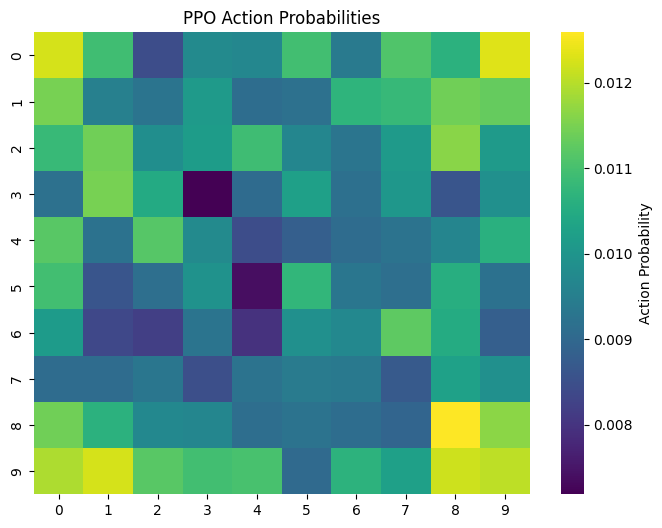


Running Evaluation...
Running 100 games (Masked=True)...
Running 100 games (Masked=False)...


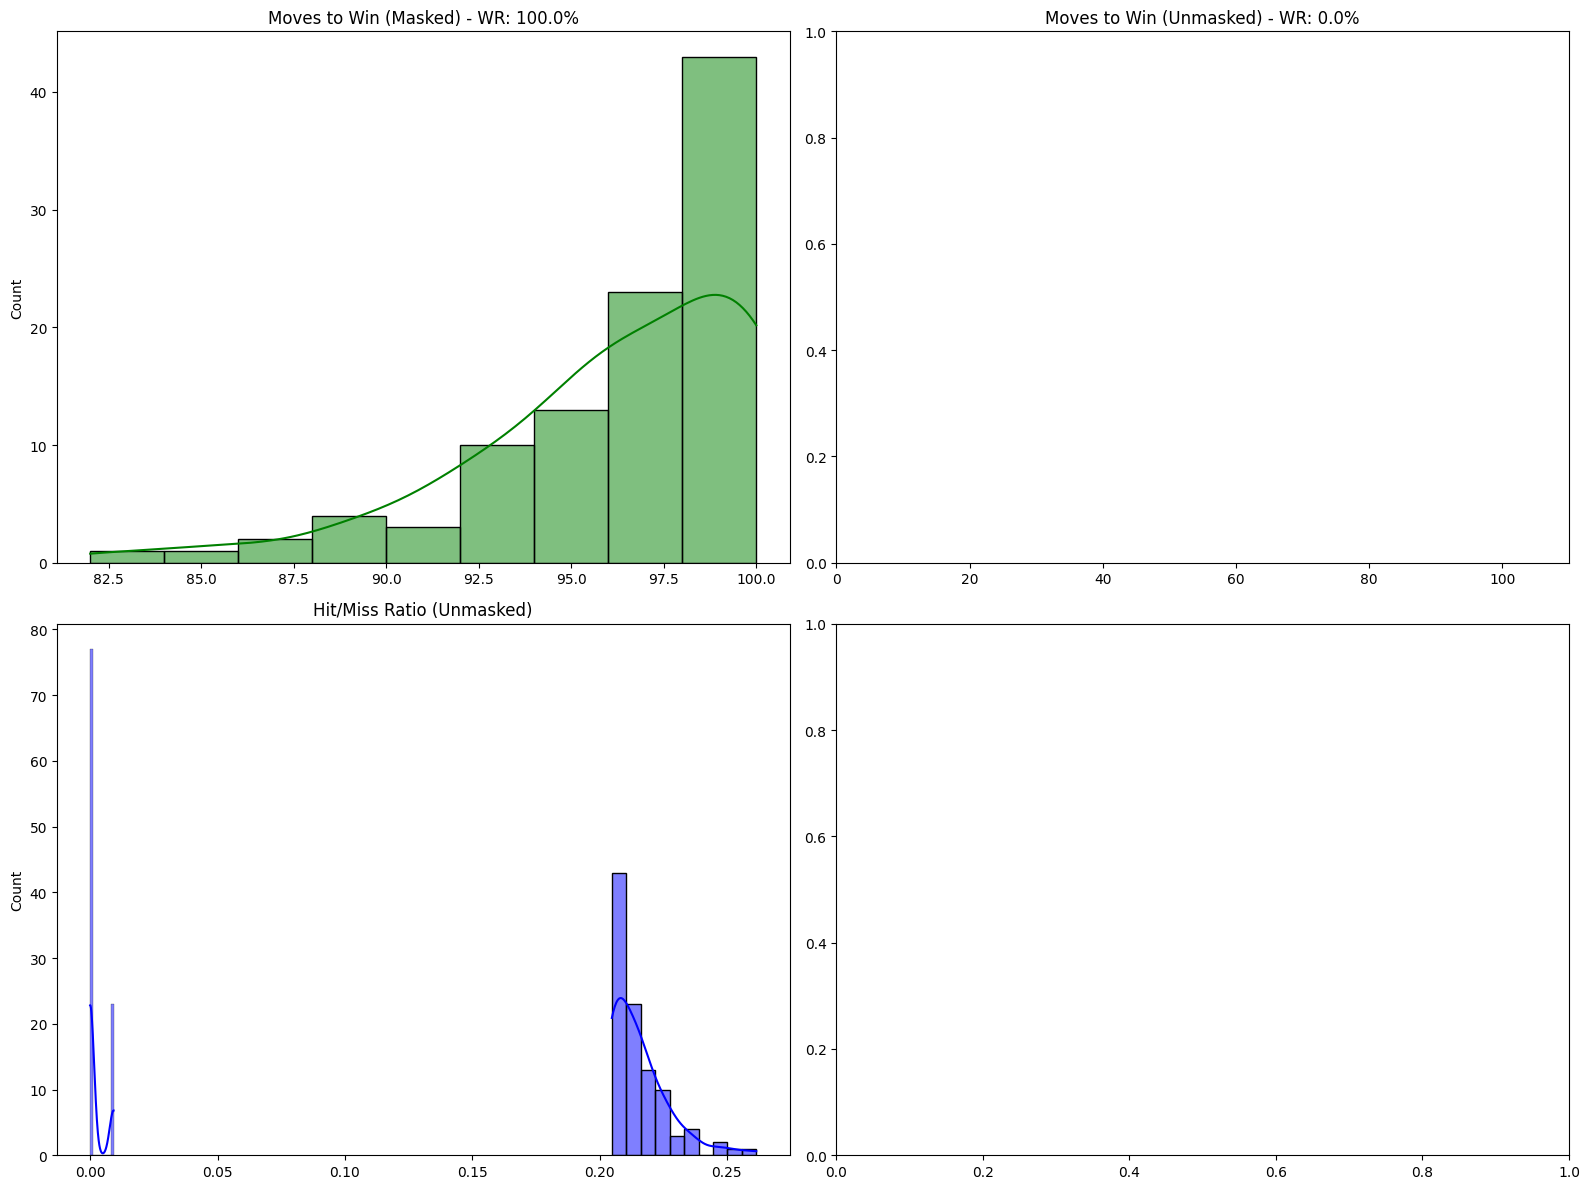

-----------------------------
PPO Model Results (Timesteps: 212992):
  Action Masking Results:
    Win Rate: 100.00%
    Avg Steps (All Games): 96.13
    Avg Reward: 300.52
    Avg Hit/Miss Ratio: 0.22
  Non-Action Masking Results:
    Win Rate: 0.00%
    Avg Steps (All Games): 110.00
    Avg Reward: -1751.34
    Avg Hit/Miss Ratio: 0.00

Stats saved to ppo-training.txt
Recording video...
Video saved to ppo_recording_eval.gif
Total frames: 100
Game ended after 99 moves
Result: WON!


In [9]:
from sb3_contrib import MaskablePPO
from sb3_contrib.common.wrappers import ActionMasker
from stable_baselines3.common.callbacks import CheckpointCallback

reward_dict = {
    'win': 100,
    'lose': -30,
    'missed': -0.2,
    'hit': 5,
    'proximal_hit': 20,
    'repeat_missed': -20,
    'repeat_hit': -3
}

MODEL_PATH = "ppo_model_final"
eval_env = BattleshipEnv(reward_dictionary=reward_dict, episode_steps=110)

try:
    policy_kwargs = dict(
        features_extractor_class=BattleshipCNN,
        features_extractor_kwargs=dict(features_dim=256),
        net_arch=dict(pi=[256, 128], vf=[256, 128]),
        normalize_images=False
    )

    model = MaskablePPO.load(
        MODEL_PATH, 
        custom_objects={"features_extractor": BattleshipCNN},
        env=eval_env
    )
    print(f"Model loaded successfully from {MODEL_PATH}.zip")
except Exception as e:
    print(f"Error loading model: {e}")

print("\nGenerating Action Probability Heatmap...")
BattleshipVisualizer.plot_heatmap(model, eval_env, title="PPO Action Probabilities")

print("\nRunning Evaluation...")
evaluator = BattleshipEvaluator(model, eval_env)

NUM_EVAL_GAMES = 100 
masked_results = evaluator.run_evaluation(num_games=NUM_EVAL_GAMES, mask=True)
unmasked_results = evaluator.run_evaluation(num_games=NUM_EVAL_GAMES, mask=False)

evaluator.plot_data(masked_results, unmasked_results)

print_and_save_stats(model, masked_results, unmasked_results)

record_ppo_video(eval_env, model, "ppo_recording_eval.gif", fps=5)

### EVALUATE HARDCODED AGENTS

In [ ]:
# evaluate hardcoded agents

NUM_GAMES = 100

env = gym.make('Battleship-v0', board_size=(10, 10), reward_dictionary=hyperparameters['rewards'])

random_agent = RandomAgent(skip_invalid_actions=True)

# 1000 games with action masking and 1000 without action masking
random_agent_results = run_games(random_agent, env, num_games=NUM_GAMES, mask=False, root_dir="./hardcoded_models/random_agent")
print("Random agent results: ")
print(random_agent_results)

env.reset()
heuristic_agent = HeuristicAgent(env, skip_invalid_actions=True)
heuristic_agent_results = run_games(heuristic_agent, env, num_games=NUM_GAMES, mask=False, root_dir="./hardcoded_models/heuristic_agent")

print("Heuristic agent results: ")
print(heuristic_agent_results)

with open (f"./hardcoded_models/random_agent/random_agent_results.txt", "a") as f:
    f.write("\t" + str(random_agent_results) + "\n")
    f.flush()

with open (f"./hardcoded_models/heuristic_agent/heuristic_agent_results.txt", "a") as f:
    f.write("\t" + str(heuristic_agent_results) + "\n")
    f.flush()